#  Imputación básica

**¿Qué significa?**

Es reemplazar estos valores con algún valor, algún estadístico que provenga de los datos, algún valor que provenga por contexto o podría venir de algún modelo de Machine Learning, o también podría venir de algún modelo que este previendo de donde vienen los datos faltantes.

#### Importando librerías

In [2]:
### Importando librerías
import janitor      #Crear pipelines de limpieza de datos
import matplotlib.pyplot as plt
import missingno    #Visualizar valores faltantes 
import numpy as np
import pandas as pd
import pyreadr      #Leer archivos adr para este curso
import seaborn as sns
import session_info
import upsetplot    #Para gráfica de relaciones 
                    #de nuestros valores faltantes

#### Configurar el aspecto general de las gráficas del proyecto

In [4]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (10, 10)
    }
)

sns.set_style("whitegrid")

#### Leer conjunto de datos

In [7]:
#Cargar conjunto de datos
riskfactors = pyreadr.read_r('dataset/riskfactors.rda')

#Convertirlo a Data Frame
riskfactors_df = next(iter(riskfactors.values()))

#Borrar el diccionario
del riskfactors

### Imputación con base en el contexto

In [5]:
implicit_to_explicit_df = pd.DataFrame(
    data={
        "name": ["lynn", np.nan, "zelda", np.nan, "shadowsong", np.nan],
        "time": ["morning", "afternoon", "morning", "afternoon", "morning", "afternoon",],
        "value": [350, 310, 320, 350, 310, 320]
    }
)

implicit_to_explicit_df

,name,time,value
0,lynn,morning,350
1,NaN,afternoon,310
2,zelda,morning,320
3,NaN,afternoon,350
4,shadowsong,morning,310
5,NaN,afternoon,320


¿Qué significa esto?

Que nosotros sabemos algo sobre la estructura de nuestros datos y que por supuesto nosotros podemos completar las entradas vacías.

Observemos en nuestros datos anteriores que tenemos algo similar a las primeras clases, en donde tenemos valores faltantes en nuestra variable `name`.

**¿Ahora que está pasando?** Nosotros vemos que para nuestra primera columna tenemos 3 posibles valores:
1. lynn
2. zelda
3. shadowsong     

En donde en cada entrada después del nombre aparece un valor faltante, también es importante ver que para todos ellos tengo una variable `time` donde todas sus entradas están completas:
- Morning
- Afternoon

**¿Qué está pasando aquí?**
En este caso nos encontramos con un set de datos en donde una persona puede que le haya dado flojera volver a escribir el nombre para diferentes entradas.

En este contexto podemos rellenar los valores y es un caso que nos podemos encontrar muy a menudo, generalmente se trata de rellenar una entrada y el resto queda vacía, rellenar otra entrada y así sucesivamente.

**Pero entonces ¿cómo podemos rellenar estas entradas por medio del contexto?**

In [6]:
(
    implicit_to_explicit_df.ffill()
)

,name,time,value
0,lynn,morning,350
1,lynn,afternoon,310
2,zelda,morning,320
3,zelda,afternoon,350
4,shadowsong,morning,310
5,shadowsong,afternoon,320


Lo que hace es que el valor faltante lo rellena con la última observación de la columna o fila anterior.

En este momento nuestros Data Frame ha sido imputado por contexto, sin embargo este es un caso muy sencillo.

### Imputación con un único valor

In [11]:
(
    riskfactors_df
    .select_columns('weight_lbs','height_inch','bmi')
)

/home/dens/miniforge3/envs/deteccion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


,weight_lbs,height_inch,bmi
0,190,64,32.68
1,170,68,25.90
2,163,64,28.04
3,230,74,29.59
4,135,62,24.74
...,...,...,...
240,144,63,25.56
241,170,74,21.87
242,175,71,24.46
243,138,64,23.74


#### Añadir extensión de Pandas

In [9]:
%run pandas-missing-extension-re2.py

In [12]:
(
    riskfactors_df
    .select_columns('weight_lbs','height_inch','bmi')
    .missing.bind_shadow_matrix(
        true_string=True,
        false_string=False,
    )
)

/home/dens/miniforge3/envs/deteccion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


,weight_lbs,height_inch,bmi,weight_lbs_NA,height_inch_NA,bmi_NA
0,190,64,32.68,False,False,False
1,170,68,25.90,False,False,False
2,163,64,28.04,False,False,False
3,230,74,29.59,False,False,False
4,135,62,24.74,False,False,False
...,...,...,...,...,...,...
240,144,63,25.56,False,False,False
241,170,74,21.87,False,False,False
242,175,71,24.46,False,False,False
243,138,64,23.74,False,False,False


Tenemos nuestra matriz de sombras que ha sido añadida a nuestro conjunto de datos.

Está perfecto, lo que vamos a rellenar cada entrenada con la media del valor de la columna.

In [13]:
(
    riskfactors_df
    .select_columns('weight_lbs','height_inch','bmi')
    .missing.bind_shadow_matrix(true_string=True,false_string=False)
    .apply(
        axis='rows',
        func=lambda column: column.fillna(column.mean() if '_NA' not in column.name else column)
    )
)

/home/dens/miniforge3/envs/deteccion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/tmp/ipykernel_90579/2511936467.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  func=lambda column: column.fillna(column.mean() if '_NA' not in column.name else column)


,weight_lbs,height_inch,bmi,weight_lbs_NA,height_inch_NA,bmi_NA
0,190.0,64.0,32.68,False,False,False
1,170.0,68.0,25.90,False,False,False
2,163.0,64.0,28.04,False,False,False
3,230.0,74.0,29.59,False,False,False
4,135.0,62.0,24.74,False,False,False
...,...,...,...,...,...,...
240,144.0,63.0,25.56,False,False,False
241,170.0,74.0,21.87,False,False,False
242,175.0,71.0,24.46,False,False,False
243,138.0,64.0,23.74,False,False,False


Ahora no tenemos valores faltantes

In [18]:
(
    riskfactors_df
    .select_columns('weight_lbs','height_inch','bmi')
    .missing.bind_shadow_matrix(true_string=True,false_string=False)
    .apply(
        axis='rows',
        func=lambda column: column.fillna(column.mean() if '_NA' not in column.name else column)
    )
).isna().sum()

/home/dens/miniforge3/envs/deteccion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/tmp/ipykernel_90579/1976632701.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  func=lambda column: column.fillna(column.mean() if '_NA' not in column.name else column)


weight_lbs        0
height_inch       0
bmi               0
weight_lbs_NA     0
height_inch_NA    0
bmi_NA            0
dtype: int64

In [17]:
(
    riskfactors_df
    .select_columns('weight_lbs','height_inch','bmi')
    .isna()
    .sum()
)

/home/dens/miniforge3/envs/deteccion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


weight_lbs     10
height_inch     2
bmi            11
dtype: int64

Como se puede observar en la tabla anterior tenemos valores faltantes, para las siguientes columnas, entonces con el código anterior, rellenamos los valores faltantes con el promedio.

### Graficando
Ahora podemos graficarlos y ver su comportamiento

/home/dens/miniforge3/envs/deteccion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/tmp/ipykernel_90579/444234580.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  func=lambda column: column.fillna(column.mean() if '_NA' not in column.name else column)


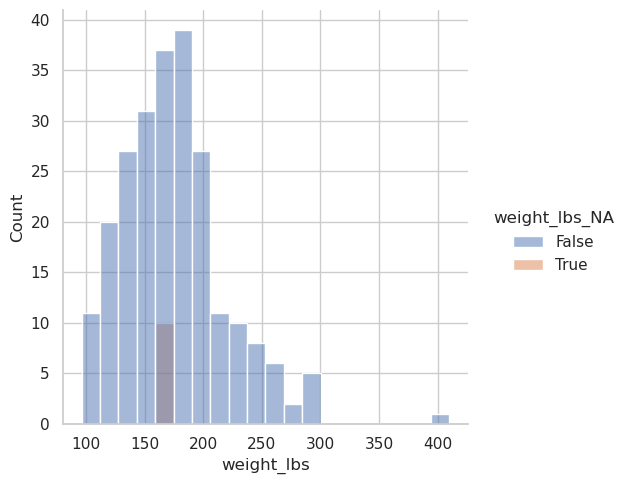

In [26]:
(
    riskfactors_df
    .select_columns('weight_lbs','height_inch','bmi')
    .missing.bind_shadow_matrix(true_string=True,false_string=False)
    .apply(
        axis='rows',
        func=lambda column: column.fillna(column.mean() if '_NA' not in column.name else column)
    )
    .pipe(
        lambda df:(
            sns.displot(
                data=df,
                x='weight_lbs',
                hue='weight_lbs_NA',
                #multiple='stack'
            )
        )
    )
)

Graficamos nuestra variable `weight_lbs` y hacemos una segmentación de acuerdo a si teníamos una observación faltante, para eso recurrimos a `weight_lbs_NA`.

Entonces tenemos nuestros valores imputados con el valor de promedio en naranja.

Ya visualizamos nuestra **imputación** en forma de distribución, ahora podemos ver nuestra **imputación** en relación con otras variables.

### Imputación con multiples variables

In [27]:
(
    riskfactors_df
    .select_columns('weight_lbs','height_inch','bmi')
    .missing.bind_shadow_matrix(true_string=True,false_string=False)
    .apply(
        axis='rows',
        func=lambda column: column.fillna(column.mean() if '_NA' not in column.name else column)
    )
    .assign(
        imputed = lambda df: df.weight_lbs_NA | df.height_inch_NA
    )
)

/home/dens/miniforge3/envs/deteccion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/tmp/ipykernel_90579/1897433853.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  func=lambda column: column.fillna(column.mean() if '_NA' not in column.name else column)


,weight_lbs,height_inch,bmi,weight_lbs_NA,height_inch_NA,bmi_NA,imputed
0,190.0,64.0,32.68,False,False,False,False
1,170.0,68.0,25.90,False,False,False,False
2,163.0,64.0,28.04,False,False,False,False
3,230.0,74.0,29.59,False,False,False,False
4,135.0,62.0,24.74,False,False,False,False
...,...,...,...,...,...,...,...
240,144.0,63.0,25.56,False,False,False,False
241,170.0,74.0,21.87,False,False,False,False
242,175.0,71.0,24.46,False,False,False,False
243,138.0,64.0,23.74,False,False,False,False


Añadimos una columna que nos dirá si hemos imputado un valor para las 2 variables que queremos graficar en un `scatterplot`. 

Es decir si tengo un valor faltante de `weight_lbs` o de `height_inch`, entonces marcalo como verdadero, para que así nosotros podamos colorear los puntos que estamos imputando.

Lo corremos y nos aseguramos que lo hemos ejecutado adecuadamente.

/home/dens/miniforge3/envs/deteccion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/tmp/ipykernel_90579/2788026571.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  func=lambda column: column.fillna(column.mean() if '_NA' not in column.name else column)


<AxesSubplot:xlabel='weight_lbs', ylabel='height_inch'>

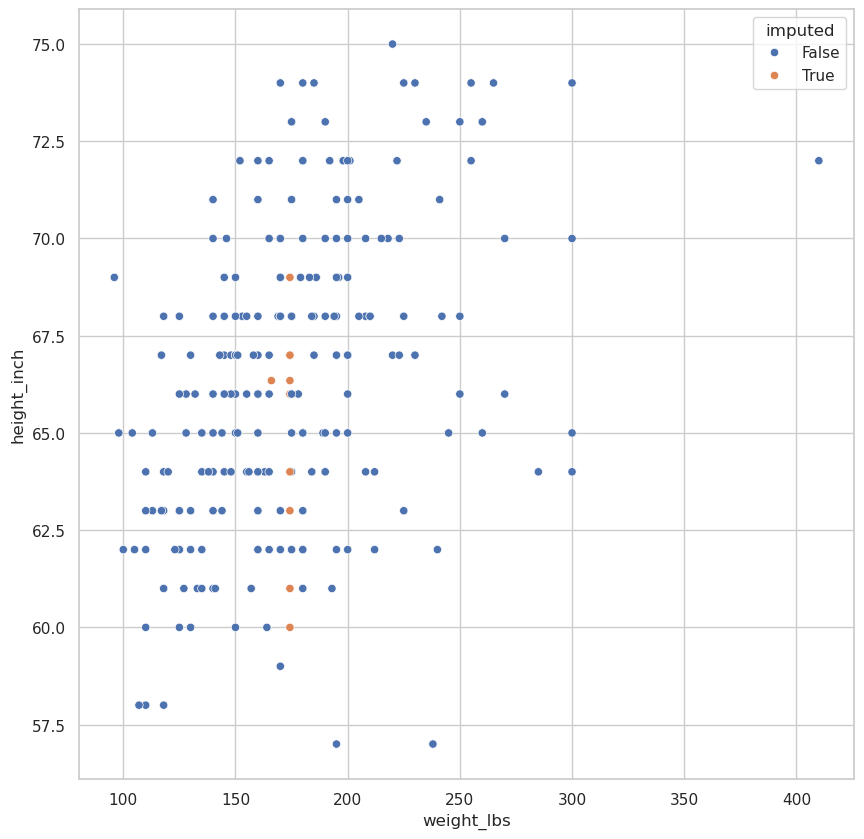

In [28]:
(
    riskfactors_df
    .select_columns('weight_lbs','height_inch','bmi')
    .missing.bind_shadow_matrix(true_string=True,false_string=False)
    .apply(
        axis='rows',
        func=lambda column: column.fillna(column.mean() if '_NA' not in column.name else column)
    )
    .assign(
        imputed = lambda df: df.weight_lbs_NA | df.height_inch_NA
    )
    .pipe(
        lambda df: (
            sns.scatterplot(
                data=df,
                x='weight_lbs',
                y='height_inch',
                hue='imputed',
            )
        )
    )
)

Recordamos en clases pasadas que teníamos estos puntos por fuera de nuestros datos reales o puntos azules.

Así incluimos los valores faltantes reemplazándolos por su promedio, entonces tenemos valores ya sea de `weight_lbs` o de `height_lbs`.

Es importante destacar que agregándolos no estamos rompiendo una relación entre las variables, eso es muy importante; porque puede que en otros casos nos demos cuenta que al agregarlos estamos rompiendo el comportamiento de la relación del conjunto de datos, entonces esto hablaría de que estamos realizando una mala imputación y que añadiría un sesgo a nuestros datos.

En este caso se ve razonable y bien.